In [1]:
import matplotlib.pyplot as plt
from strategies import SignalSignatureStrategy
from volume_based_indicator import *

# Initial settings
transaction_currency = "ETH"
counter_currency = "BTC"
end_time = 1531699200
start_time = end_time - 60 * 60 * 24 * 45
resample_period = 60
start_cash = 1
start_crypto = 0
source = 0
strength = 3
history_size = 100
AVERAGING_PERIOD = 50*60

# fill kwargs structure, needed later
kwargs = {}
kwargs['source'] = source
kwargs['transaction_currency'] = transaction_currency
kwargs['counter_currency'] = counter_currency
kwargs['start_time'] = start_time
kwargs['end_time'] = end_time
kwargs['resample_period'] = resample_period
kwargs['start_cash'] = 1
kwargs['start_crypto'] = 0
kwargs['evaluate_profit_on_last_order'] = False

sell_strategy = SignalSignatureStrategy(["rsi_buy_2", "rsi_sell_2", "rsi_buy_3", "rsi_sell_3"])

price_volume_df = build_resampled_price_volume_df(start_time, end_time, transaction_currency, counter_currency, resample_period, source)
write_to_excel(price_volume_df, "df.xlsx")

 --> reduced size of volume dataframe from 62978 to 62975 because of duplicate data.


In [2]:
# First test of a VBI-based strategy
strategy_signals, all_buy_signals, first_cross_buy_signals = build_strategy_signals(price_volume_df, 0, 0, 
                                                                    buy_only_on_first_cross=True, sell_strategy=sell_strategy, **kwargs)
backtest = SignalDrivenBacktester(strategy=sell_strategy, signals=strategy_signals, **kwargs)

INFO:root:Strategy: a simple signal set-based strategy
  description: trading according to signal set ['rsi_buy_2', 'rsi_sell_2', 'rsi_buy_3', 'rsi_sell_3']
--

* Order execution log *

Start balance: cash = 1 BTC, crypto = 0 
Start time: 2018-06-01 00:00:00
--
--
2018-06-02 16:00:00  	 OrderType.BUY    	 cash_balance ->         -1.00 BTC 	 currency_balance ->     12.854381 ETH 	 (1 ETH = 0.07760000 BTC ), slippage = 0.00
   signal: rsi_buy_3 strength=3 trend=1 horizon=Horizon.any timestamp=2018-06-02 16:00:00 rsi_value=0
2018-06-19 12:08:00  	 OrderType.SELL   	 cash_balance ->          1.02 BTC 	 currency_balance ->    -12.854381 ETH 	 (1 ETH = 0.07967969 BTC ), slippage = 0.00
   signal: rsi_sell_2 strength=2 trend=-1 horizon=0 timestamp=2018-06-19 12:08:00 rsi_value=77.2212983395951
2018-06-21 07:00:00  	 OrderType.BUY    	 cash_balance ->         -1.02 BTC 	 currency_balance ->     12.715500 ETH 	 (1 ETH = 0.08014772 BTC ), slippage = 0.00
   signal: rsi_buy_3 strength=3 trend=1 h

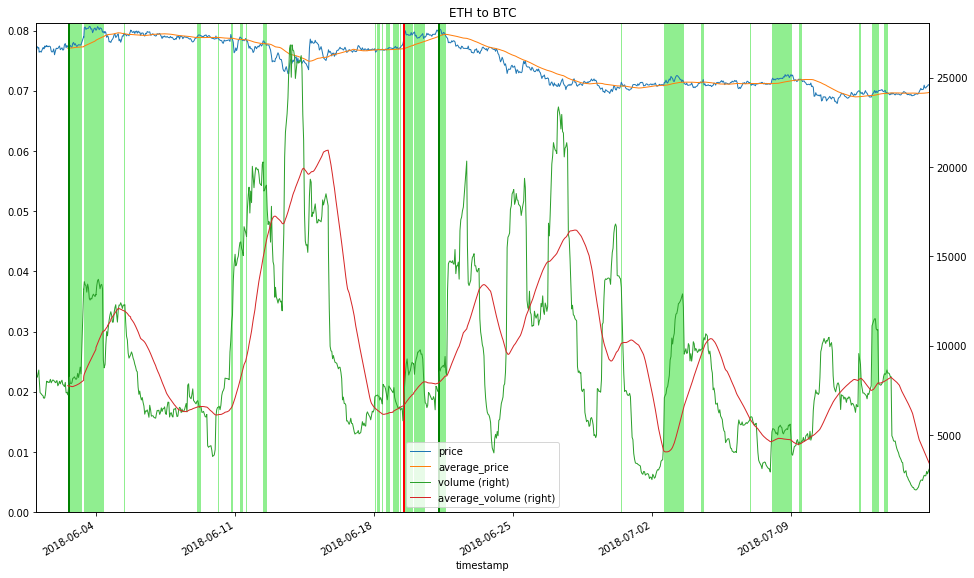

,price,average_price,volume,average_volume
timestamp,,,,
2018-06-01 00:00:00+00:00,0.076825,NaN,8394.317723,NaN
2018-06-01 00:19:00+00:00,0.076820,NaN,8314.118889,NaN
2018-06-01 01:05:00+00:00,0.077334,NaN,8244.645570,NaN
2018-06-01 02:31:00+00:00,0.077133,NaN,8540.949069,NaN
2018-06-01 03:00:00+00:00,0.077160,NaN,8647.849383,NaN
2018-06-01 03:24:00+00:00,0.076419,NaN,8209.255548,NaN
2018-06-01 04:31:00+00:00,0.076578,NaN,7387.601288,NaN
2018-06-01 05:55:00+00:00,0.076430,NaN,7318.318358,NaN
2018-06-01 06:26:00+00:00,0.076625,NaN,7277.615705,NaN


In [3]:
plot_results(price_volume_df, transaction_currency, counter_currency, all_buy_signals,
             first_cross_buy_signals, backtest.get_orders(), include_all_buy=True, include_first_cross=False, include_orders=True)

price_volume_df

INFO:root:Strategy: a simple signal set-based strategy
  description: trading according to signal set ['rsi_buy_2', 'rsi_sell_2', 'rsi_buy_3', 'rsi_sell_3']
--

* Order execution log *

Start balance: cash = 1 BTC, crypto = 0 
Start time: 2018-06-01 00:00:00
--
--
2018-06-02 16:00:00  	 OrderType.BUY    	 cash_balance ->         -1.00 BTC 	 currency_balance ->     12.854381 ETH 	 (1 ETH = 0.07760000 BTC ), slippage = 0.00
   signal: rsi_buy_3 strength=3 trend=1 horizon=Horizon.any timestamp=2018-06-02 16:00:00 rsi_value=0
2018-06-19 12:08:00  	 OrderType.SELL   	 cash_balance ->          1.02 BTC 	 currency_balance ->    -12.854381 ETH 	 (1 ETH = 0.07967969 BTC ), slippage = 0.00
   signal: rsi_sell_2 strength=2 trend=-1 horizon=0 timestamp=2018-06-19 12:08:00 rsi_value=77.2212983395951
2018-06-21 07:00:00  	 OrderType.BUY    	 cash_balance ->         -1.02 BTC 	 currency_balance ->     12.715500 ETH 	 (1 ETH = 0.08014772 BTC ), slippage = 0.00
   signal: rsi_buy_3 strength=3 trend=1 h

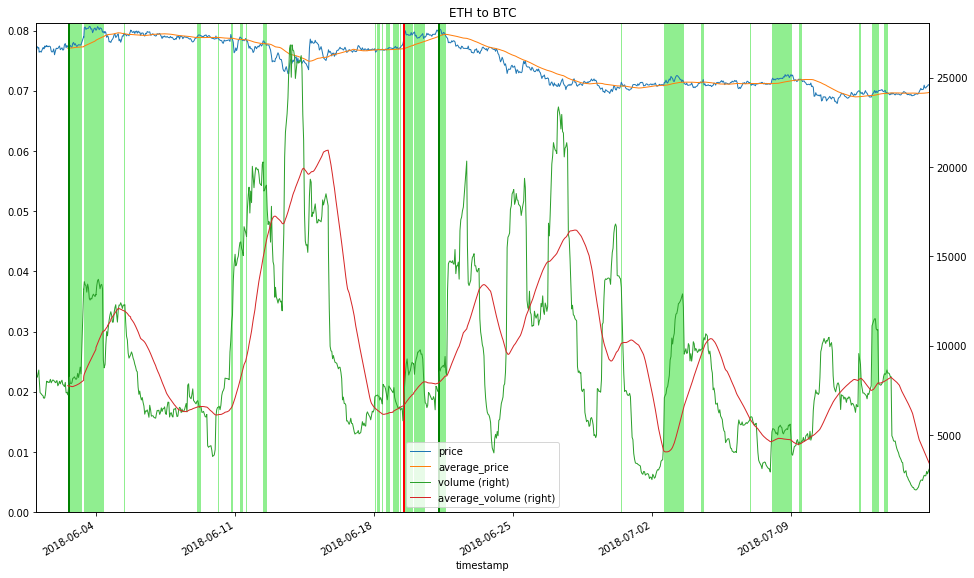

In [4]:
# Let's try another threshold

strategy_signals, all_buy_signals, first_cross_buy_signals = build_strategy_signals(price_volume_df, 0, 0, 
                                                                    buy_only_on_first_cross=True, sell_strategy=sell_strategy, **kwargs)
backtest = SignalDrivenBacktester(strategy=sell_strategy, signals=strategy_signals, **kwargs)
plot_results(price_volume_df, transaction_currency, counter_currency, all_buy_signals,
             first_cross_buy_signals, backtest.get_orders(), include_all_buy=True, include_first_cross=False, include_orders=True)



In [5]:
overbought_threshold = 95
oversold_threshold = 25
profit_df = calculate_profits(price_volume_df, sell_strategy, **kwargs)

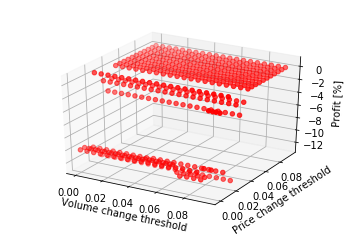

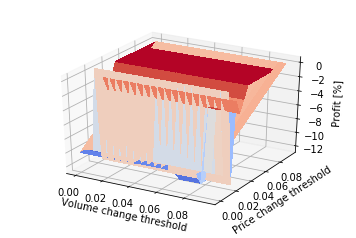

In [6]:
profit_df
plot_profit_df(profit_df)

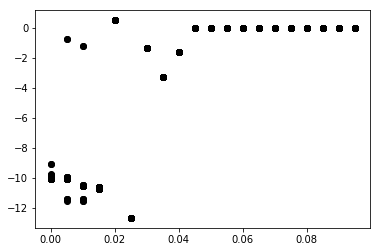

In [7]:
plt.plot(profit_df["Price change percent"], profit_df["Profit percent"], 'o', color='black');

In [8]:
# Find best performing parameters
sorted_by_profit = profit_df.sort_values("Profit percent", inplace=False, ascending=False)
sorted_by_profit

,Volume change percent,Price change percent,Profit percent
224,0.055,0.020,0.487444
124,0.030,0.020,0.487444
84,0.020,0.020,0.487444
64,0.015,0.020,0.487444
204,0.050,0.020,0.487444
384,0.095,0.020,0.487444
344,0.085,0.020,0.487444
244,0.060,0.020,0.487444
184,0.045,0.020,0.487444
44,0.010,0.020,0.487444


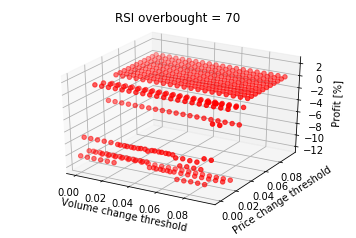

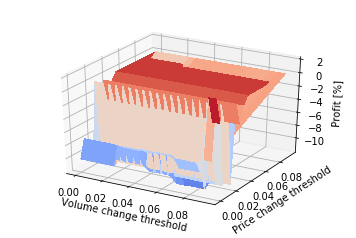

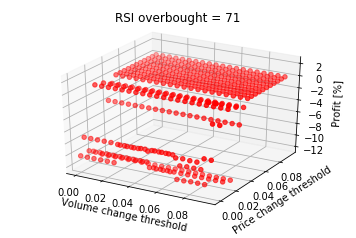

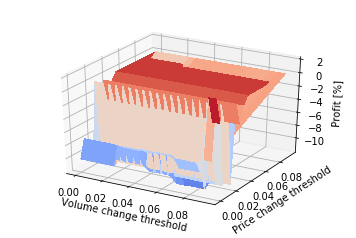

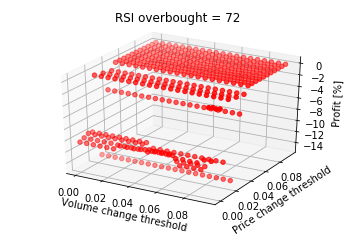

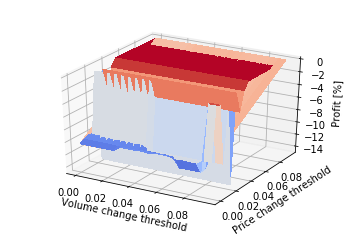

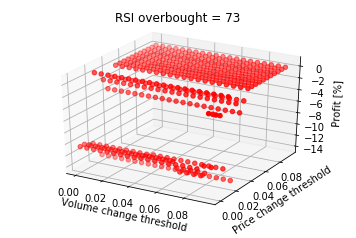

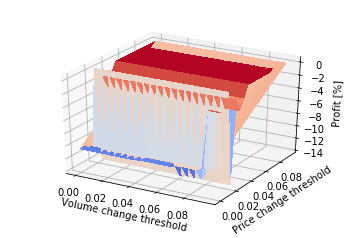

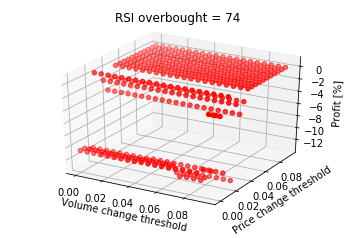

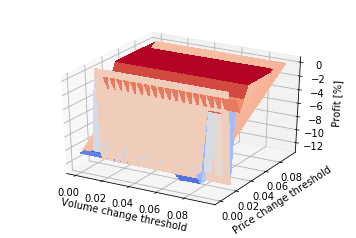

In [9]:
# Explore how RSI overbought influences the results
from strategies import SimpleRSIStrategy
all_results = None
oversold_threshold = 20 # not used
for overbought_threshold in range(70,75):
    sell_strategy = SimpleRSIStrategy(overbought_threshold, oversold_threshold, "RSI")
    profit_df = calculate_profits(price_volume_df, sell_strategy, **kwargs)
    profit_df['RSI overbought'] = pd.Series([overbought_threshold] * len(profit_df), index=profit_df.index)
    if all_results is None:
        all_results = profit_df
    else:
        all_results = all_results.append(profit_df, ignore_index=True)
    plot_profit_df(profit_df, "RSI overbought = {}".format(overbought_threshold))

In [10]:
all_results


,Volume change percent,Price change percent,Profit percent,RSI overbought
0,0.000,0.000,-10.216654,70
1,0.000,0.005,-7.452221,70
2,0.000,0.010,-10.150131,70
3,0.000,0.015,-10.613445,70
4,0.000,0.020,0.081164,70
5,0.000,0.025,-11.927207,70
6,0.000,0.030,-0.306607,70
7,0.000,0.035,-3.527048,70
8,0.000,0.040,-1.074169,70
9,0.000,0.045,0.000000,70


In [11]:
sorted_by_profit = all_results.sort_values("Profit percent", inplace=False, ascending=False)
sorted_by_profit

,Volume change percent,Price change percent,Profit percent,RSI overbought
781,0.095,0.005,2.037427,71
381,0.095,0.005,2.037427,70
761,0.090,0.005,2.037427,71
361,0.090,0.005,2.037427,70
1524,0.080,0.020,0.487444,73
1844,0.060,0.020,0.487444,74
1464,0.065,0.020,0.487444,73
1724,0.030,0.020,0.487444,74
1544,0.085,0.020,0.487444,73
1284,0.020,0.020,0.487444,73


INFO:root:Strategy: a simple RSI-based strategy
  description: selling when rsi_value >= overbought_threshold, buying when rsi_value <= oversold threshold 
Strategy settings:
  overbought_threshold = 71.0
  oversold_threshold = 20
--

* Order execution log *

Start balance: cash = 1 BTC, crypto = 0 
Start time: 2018-06-01 00:00:00
--
--
2018-06-03 09:11:00  	 OrderType.BUY    	 cash_balance ->         -1.00 BTC 	 currency_balance ->     12.627116 ETH 	 (1 ETH = 0.07899666 BTC ), slippage = 0.00
   signal: rsi_buy_3 strength=3 trend=1 horizon=Horizon.any timestamp=2018-06-03 09:11:00 rsi_value=0
2018-06-03 10:00:00  	 OrderType.SELL   	 cash_balance ->          1.01 BTC 	 currency_balance ->    -12.627116 ETH 	 (1 ETH = 0.08054288 BTC ), slippage = 0.00
   signal: rsi_sell_1 strength=1 trend=-1 horizon=0 timestamp=2018-06-03 10:00:00 rsi_value=71.0804318309633
2018-06-10 19:03:00  	 OrderType.BUY    	 cash_balance ->         -1.01 BTC 	 currency_balance ->     12.749722 ETH 	 (1 ETH = 0

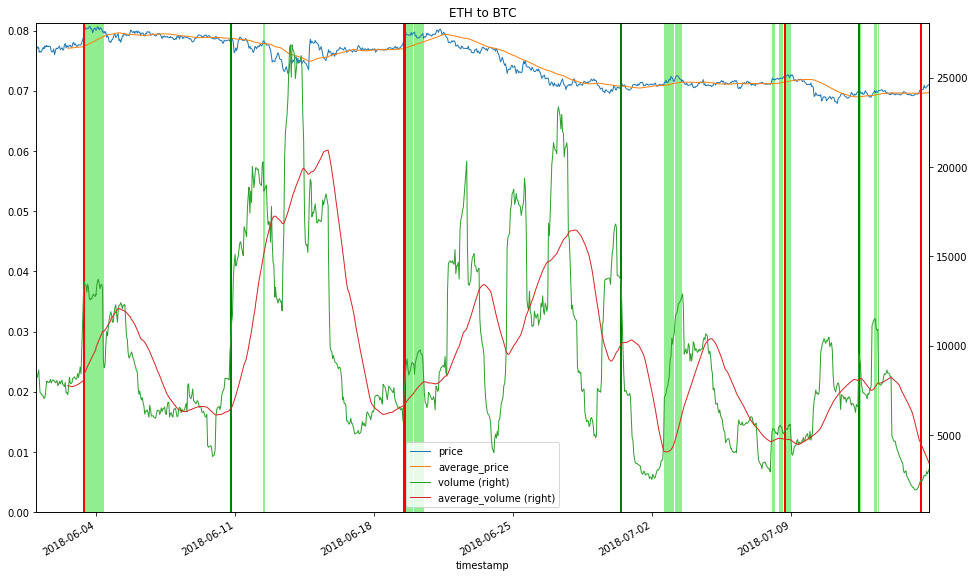

In [13]:
# Analyze the best parameter combination
overbought_threshold = sorted_by_profit.iloc[0]["RSI overbought"]
percent_change_volume = sorted_by_profit.iloc[0]["Volume change percent"]
percent_change_price = sorted_by_profit.iloc[0]["Price change percent"]


sell_strategy = SimpleRSIStrategy(overbought_threshold, oversold_threshold, "RSI")
strategy_signals, all_buy_signals, first_cross_buy_signals = build_strategy_signals(price_volume_df, percent_change_price, percent_change_volume, 
                                                                    buy_only_on_first_cross=True, sell_strategy=sell_strategy, **kwargs)
backtest = SignalDrivenBacktester(strategy=sell_strategy, signals=strategy_signals, **kwargs)
plot_results(price_volume_df, transaction_currency, counter_currency, all_buy_signals,
             first_cross_buy_signals, backtest.get_orders(), include_all_buy=True, include_first_cross=False, include_orders=True)

In [14]:
# Let's establish the buy and hold and RSI baselines
from strategies import BuyAndHoldTimebasedStrategy, SimpleRSIStrategy
bah = BuyAndHoldTimebasedStrategy(start_time, end_time, transaction_currency, counter_currency)
bah_evaluation = SignalDrivenBacktester(strategy=bah, **kwargs)

rsi_strat = SimpleRSIStrategy(75, 25, "RSI")
rsi_strat_evaluation = SignalDrivenBacktester(strategy=rsi_strat, **kwargs)

INFO:root:<strategies.BuyAndHoldTimebasedStrategy object at 0x10f3889b0>
--

* Order execution log *

Start balance: cash = 1 BTC, crypto = 0 
Start time: 2018-06-01 00:00:00
--
--
2018-06-01 00:00:00  	 OrderType.BUY    	 cash_balance ->         -1.00 BTC 	 currency_balance ->     12.937742 ETH 	 (1 ETH = 0.07710001 BTC ), slippage = 0.00
2018-07-16 00:00:00  	 OrderType.SELL   	 cash_balance ->          0.91 BTC 	 currency_balance ->    -12.937742 ETH 	 (1 ETH = 0.07073000 BTC ), slippage = 0.00
End time: 2018-07-16 00:00:00

Summary
--
Number of trades: 2
End cash: 0.91 BTC
End crypto: 0.000000 ETH
End price: 0.07073
Total value invested: 1 BTC
Total value after investment: 0.91 BTC (-8.72%)
Profit: -0.09 BTC
Total value invested: 7485.00 USDT (conversion on 2018-06-01 00:00:00)
Total value after investment: 5790.01 USDT (-22.65%) (conversion on 2018-07-16 00:00:00)
Profit: -1694.99 USDT

Additional stats:
  Max drawdown: 0.0
  Max drawdown duration: 0
  Sharpe ratio: nan
  Alpha: n

INFO:root:Strategy: a simple RSI-based strategy
  description: selling when rsi_value >= overbought_threshold, buying when rsi_value <= oversold threshold 
Strategy settings:
  overbought_threshold = 75
  oversold_threshold = 25
--

* Order execution log *

Start balance: cash = 1 BTC, crypto = 0 
Start time: 2018-06-01 00:00:00
--
--
2018-06-24 17:00:00  	 OrderType.BUY    	 cash_balance ->         -1.00 BTC 	 currency_balance ->     13.585291 ETH 	 (1 ETH = 0.07342500 BTC ), slippage = 0.00
   signal: rsi_buy_2 strength=2 trend=1 horizon=0 timestamp=2018-06-24 17:00:00 rsi_value=23.3773255288937
End time: 2018-07-16 00:00:00

Summary
--
Number of trades: 1
End cash: 0.00 BTC
End crypto: 13.585291 ETH
End price: 0.07073
Total value invested: 1 BTC
Total value after investment: 0.96 BTC (-3.91%)
Profit: -0.04 BTC
Total value invested: 7485.00 USDT (conversion on 2018-06-01 00:00:00)
Total value after investment: 6110.84 USDT (-18.36%) (conversion on 2018-07-16 00:00:00)
Profit: -1374.1